# SF-Crime Kaggle Challenge      2.23.16
### Data Science 2016 - CYOA Project.
_______________________________________________________

### Olin College
### David Abrahams & Brenna Manning


###### We learned some cool things and we would like to share our work with you!

## Set-up and Imports

In [1]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from patsy import dmatrix
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

/home/brenna/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
cur_dir = os.path.dirname('__file__')

train = pd.read_csv(os.path.join(cur_dir, "data", "train.csv"))
test = pd.read_csv(os.path.join(cur_dir, "data", "test.csv"))
mapdata = np.loadtxt(os.path.join(cur_dir, "data", "sf_map.txt"))

### Some helper functions. Note we do all our preprocessing in one function.

In [5]:
def get_random_subset(df, n=None):
    if (n is None):
        return df
    sub = random.sample(xrange(len(df)), min(n, len(df)))
    return df.iloc[sub]

def preprocess(df, drop=True):
    res = df.copy()
    if (drop):
        res = res[res.X != res.X.max()]
    datetimes = res.Dates.apply(get_datetime)
    res['Hour'] = datetimes.apply(lambda dt: dt.hour)
    res['Hour_Reordered'] = datetimes.apply(lambda dt: (dt.hour - 5) % 24)
    res['Month'] = datetimes.apply(lambda dt: dt.month)
    res['Hour_Minutes'] = datetimes.apply(lambda dt: dt.hour + dt.minute / 60.0)
    res['Minute'] = datetimes.apply(lambda dt: dt.minute)
    res['Year'] = datetimes.apply(lambda dt: dt.year)
    res['Minutes_Since_03'] = datetimes.apply(lambda dt: (dt-datetime(2003, 1, 1)).total_seconds() / 60)
    res['Minutes_Since_New_Year'] = datetimes.apply(lambda dt: (dt-datetime(dt.year, 1, 1)).total_seconds() / 60)
    res['Street_Corner'] = res['Address'].apply(lambda x: 1 if '/' in x else 0)
    res['Weekend'] = res.DayOfWeek.apply(lambda x: "Weekend" if x in ["Saturday", "Sunday"] else "Weekday")
    res['WorkNextDay'] = res.DayOfWeek.apply(lambda x: "No Work" if x in ["Saturday", "Friday"] else "Work")
    res['DOW_Index'] = res.DayOfWeek.apply(lambda x: dow.index(x))
    res['DayorNight'] = res.Hour_Minutes.apply(lambda x: "Day" if x > 6 and x < 20 else "Night")
    res['Midnight'] = (res.Hour == 0) & (res.Minute == 1)
    res['Noon'] = (res.Hour == 12) & (res.Minute == 0)
    
    return res

dow = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def get_datetime(s):
    dt = datetime.strptime(s, "%Y-%m-%d %H:%M:%S")
    return dt

In [7]:
train_df = preprocess(get_random_subset(train))
all_categories = train_df.Category.value_counts().index

## Time for data exploration!

/home/brenna/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


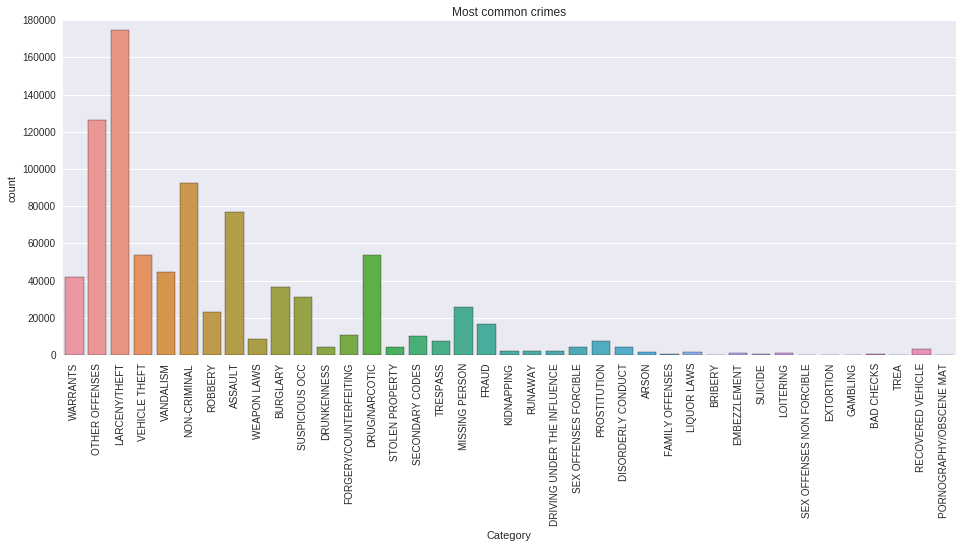

In [8]:
ax = sns.countplot(x="Category", data=train_df)
plt.sca(ax)
plt.xticks(rotation=90)
plt.gcf().set_size_inches(16, 6, forward=True)
plt.title("Most common crimes")

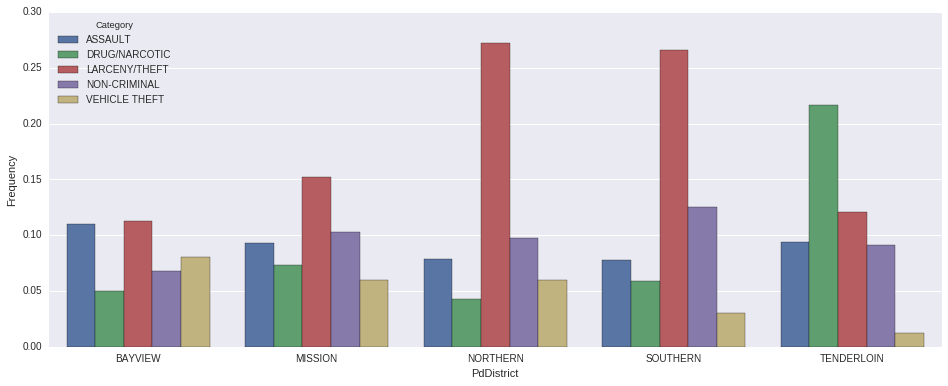

In [9]:
most_common_cats = all_categories.drop("OTHER OFFENSES")[0:5]
most_common_districs = list(train_df.PdDistrict.value_counts().index[0:4])
most_common_districs.append('TENDERLOIN') # Because Tenderloin has all the drugs.

freqs = pd.DataFrame({'count' : train_df.groupby( ["Category", "PdDistrict"] ).size()}).reset_index()
wknd_totals = freqs.PdDistrict.map(dict(train_df.groupby( "PdDistrict" ).size()))
freqs["freq"] = freqs["count"].divide(wknd_totals)
freqs_filt = freqs[freqs.Category.isin(most_common_cats) & freqs.PdDistrict.isin(most_common_districs)]

sns.barplot(data=freqs_filt, x="PdDistrict", y="freq", hue="Category")
plt.ylabel("Frequency")
plt.gcf().set_size_inches(16, 6, forward=True)

### This graph shows the frequency for each crime in each district. Interesting that drugs make up rougly 6% of crimes in most districts, but 22% in Tenderloin. Also pretty cool how much more common Larceny is in Northern and Southern

### Let's check out if weekends are special:

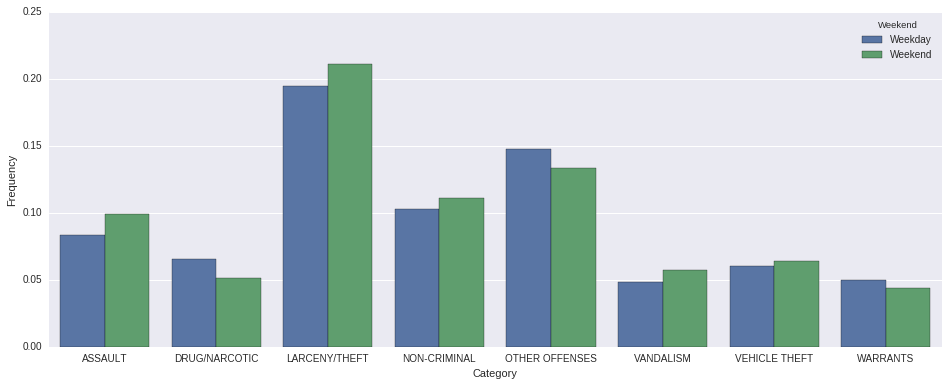

In [10]:
most_common_cats = all_categories[0:8]

freqs = pd.DataFrame({'count' : train_df.groupby( ["Category", "Weekend"] ).size()}).reset_index()
wknd_totals = freqs.Weekend.map(dict(train_df.groupby( "Weekend" ).size()))
freqs["freq"] = freqs["count"].divide(wknd_totals)
freqs_filt = freqs[freqs.Category.isin(most_common_cats)]

sns.barplot(data=freqs_filt, x="Category", y="freq", hue="Weekend")
plt.ylabel("Frequency")
plt.gcf().set_size_inches(16, 6, forward=True)

### Well that's disappointing. Maybe there's something special about Fridays and Saturdays?

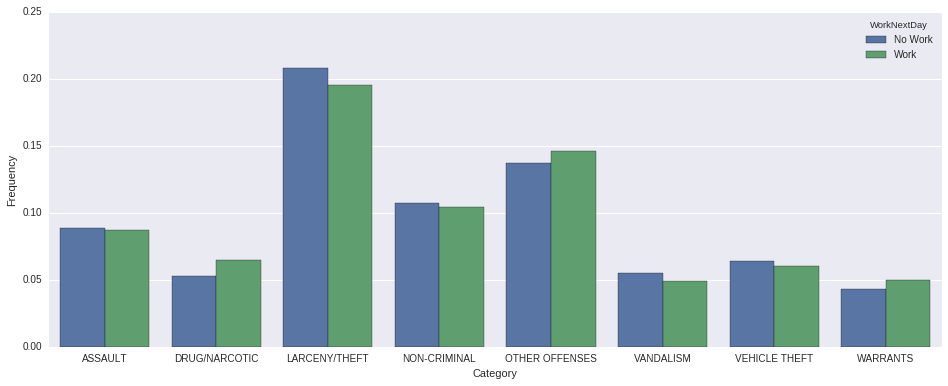

In [11]:
freqs = pd.DataFrame({'count' : train_df.groupby( ["Category", "WorkNextDay"] ).size()}).reset_index()
wknd_totals = freqs.WorkNextDay.map(dict(train_df.groupby( "WorkNextDay" ).size()))
freqs["freq"] = freqs["count"].divide(wknd_totals)
freqs_filt = freqs[freqs.Category.isin(most_common_cats)]

sns.barplot(data=freqs_filt, x="Category", y="freq", hue="WorkNextDay")
plt.ylabel("Frequency")
plt.gcf().set_size_inches(16, 6, forward=True)

### Nope again...Let's try plotting the frequency of each crime over the course of the days of the week:

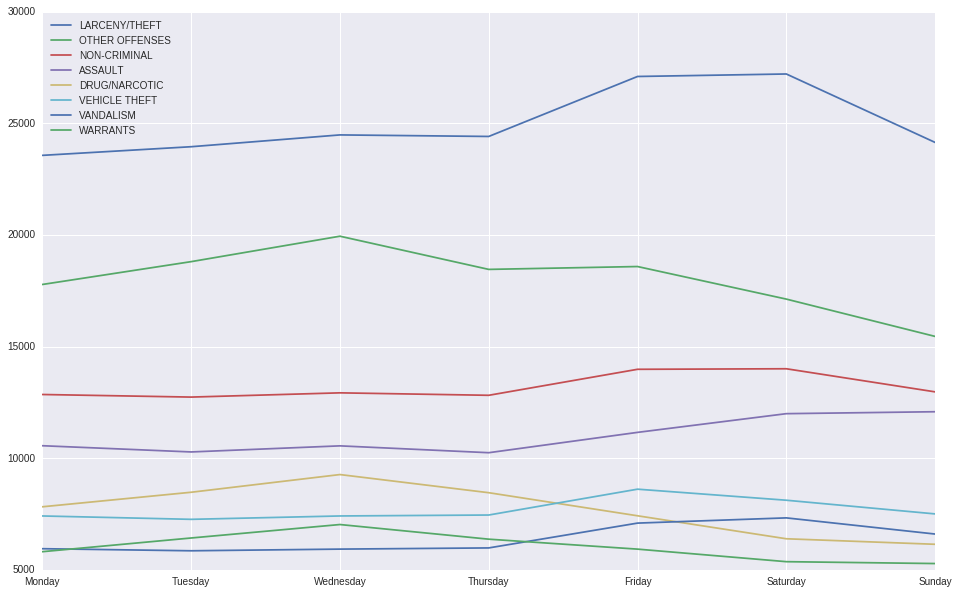

In [12]:
for c in all_categories[0:8]:
    subset = train_df[train_df.Category == c]
    groups = subset.groupby("DOW_Index")
    days = [g.DOW_Index.mean() for _, g in groups]
    crimes = [len(g) for _, g in groups]
    plt.plot(days, crimes, label=c)
plt.legend(loc=2)
plt.gcf().set_size_inches(16, 10, forward=True)
plt.gca().set_xticklabels(dow);

### It seems like Day of the Week on its own is not a good indicator for the most common crimes. Let's see if whether or not a crime occurred on a street corner (the address name contain a '/') was at all predictive.

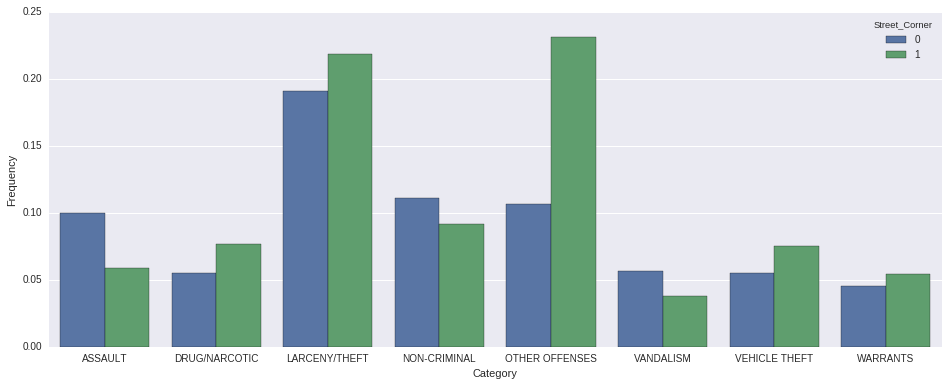

In [13]:
most_common_cats = all_categories[0:8]

freqs = pd.DataFrame({'count' : train_df.groupby( ["Category", "Street_Corner"] ).size()}).reset_index()
wknd_totals = freqs.Street_Corner.map(dict(train_df.groupby( "Street_Corner" ).size()))
freqs["freq"] = freqs["count"].divide(wknd_totals)
freqs_filt = freqs[freqs.Category.isin(most_common_cats)]

sns.barplot(data=freqs_filt, x="Category", y="freq", hue="Street_Corner")
plt.ylabel("Frequency")
plt.gcf().set_size_inches(16, 6, forward=True)

### This is interesting. Assults don't happen on street corners, other offenses do. Let's see more granularity in our data.

### Let's investigate time of day

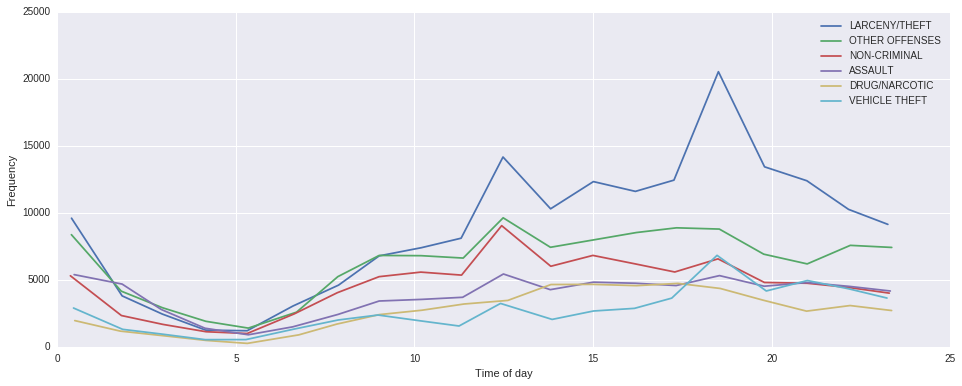

In [14]:
bins = np.linspace(0, 24, 20, False)
for c in all_categories[0:6]:
    subset = train_df[train_df.Category == c]
    indices = np.digitize(subset.Hour_Minutes, bins)
    groups = subset.groupby(indices)
    times = [g.Hour_Minutes.mean() for i, g in groups]
    crimes = [len(g) for i, g in groups]
    plt.plot(times, crimes, label=c)
plt.legend()
plt.gcf().set_size_inches(16, 6, forward=True)
plt.ylabel("Frequency")
plt.xlabel("Time of day")

### It seems like time of day is specifically important for Larceny/Theft. Let's break it down by day of the week for Larceny:

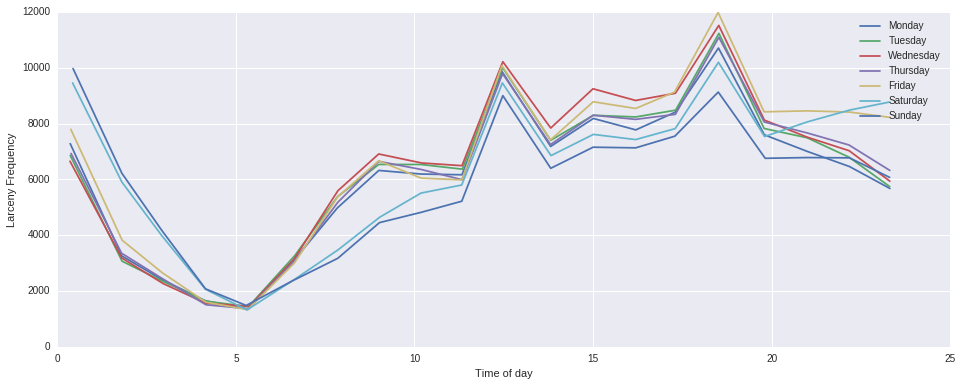

In [15]:
bins = np.linspace(0, 24, 20, False)
for d in dow:
    subset = train_df[train_df.DayOfWeek == d]
    indices = np.digitize(subset.Hour_Minutes, bins)
    groups = subset.groupby(indices)
    times = [g.Hour_Minutes.mean() for i, g in groups]
    crimes = [len(g) for i, g in groups]
    plt.plot(times, crimes, label=d)
plt.legend()
plt.gcf().set_size_inches(16, 6, forward=True)
plt.ylabel("Larceny Frequency")
plt.xlabel("Time of day")

### It's kinda interesting from roughly 8pm-6am Larceny is a lot more common on weekends, and from 6am-12pm it's more common on weekdays.

### Let's explore the location variables in our data set. First, we create some helper functions for making a hexbin graph, and then for comparing day vs. night and weekend vs. weekday.

In [16]:
def hexbin_image(df, title=None, color=plt.cm.Blues, vmax=250, cat=None):
    
    if (cat is not None):
        df = df[df.Category == cat]
    
    lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)

    imgplot = plt.imshow(mapdata, cmap=plt.get_cmap('gray'),extent=lon_lat_box)
    plt.hexbin(df.X, df.Y, gridsize=40, cmap=color,
               extent=lon_lat_box, alpha=0.5, vmin=0, vmax=vmax)
    if (title is None):
        print 'hello'
        plt.title('%s by Location' % df.Category.mode().values[0])
    else:
        plt.title(title)
        
def day_vs_night_plot(df, cat=None):
    if (cat is not None):
        df = df[df.Category == cat]
    f, axtuple = plt.subplots(1, 2, sharey=True)
    colors = {"Day": plt.cm.Oranges, "Night": plt.cm.Blues}
    for i, light in enumerate(["Day", "Night"]):
        subset = df[df.DayorNight == light]
        plt.sca(axtuple[i])
        hexbin_image(subset, title='%s during the %s' % (df.Category.mode().values[0], light), color=colors[light])        

def weekday_weekend_plot(df, cat=None):
    if (cat is not None):
        df = df[df.Category == cat]
    f, axtuple = plt.subplots(1, 2, sharey=True)
    colors = {"Weekend": plt.cm.Greens, "Weekday": plt.cm.Purples}
    for i, day in enumerate(["Weekday", "Weekend"]):
        subset = df[df.Weekend == day]
        plt.sca(axtuple[i])
        hexbin_image(subset, title='%s during the %s' % (df.Category.mode().values[0], day), color=colors[day])

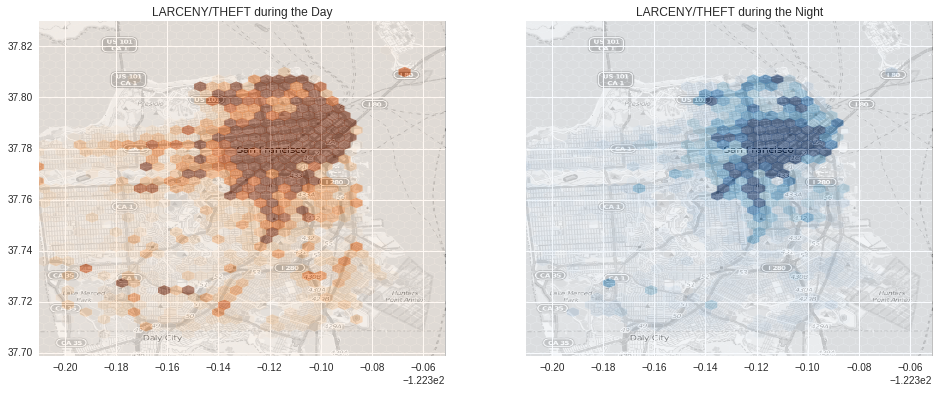

In [17]:
day_vs_night_plot(train_df, cat="LARCENY/THEFT")
plt.gcf().set_size_inches(16, 6)

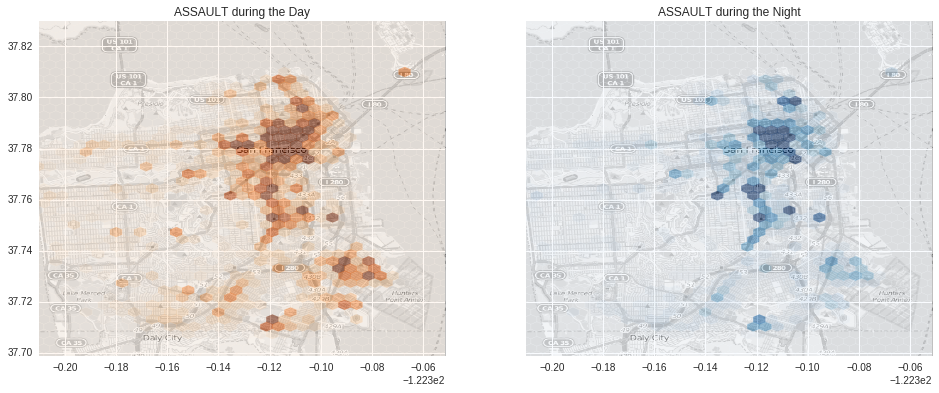

In [18]:
day_vs_night_plot(train_df, cat="ASSAULT")
plt.gcf().set_size_inches(16, 6)

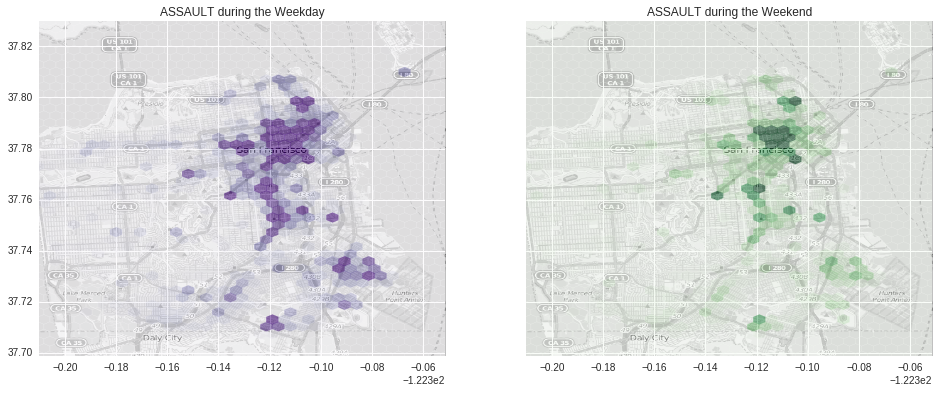

In [19]:
weekday_weekend_plot(train_df, cat="ASSAULT")
plt.gcf().set_size_inches(16, 6)

In [20]:
def heat_plot(df, category):
    y, x = np.mgrid[0:25, 0:8]
    z = np.zeros(y.shape)
    grouped = train_df.groupby("Category")
    subset = grouped.get_group(category)
    more_groups = subset.groupby(["DOW_Index", "Hour"])
    for name, group in more_groups:
        z[name[1], name[0]] = len(group)
    plt.pcolor(x, y, z, cmap='YlOrRd')
    plt.gca().set_xticklabels(dow)
    plt.ylabel("Hour")
    plt.title("Day-time distribution of %s" % category)
    plt.axis([x.min(), x.max(), y.min(), y.max()])

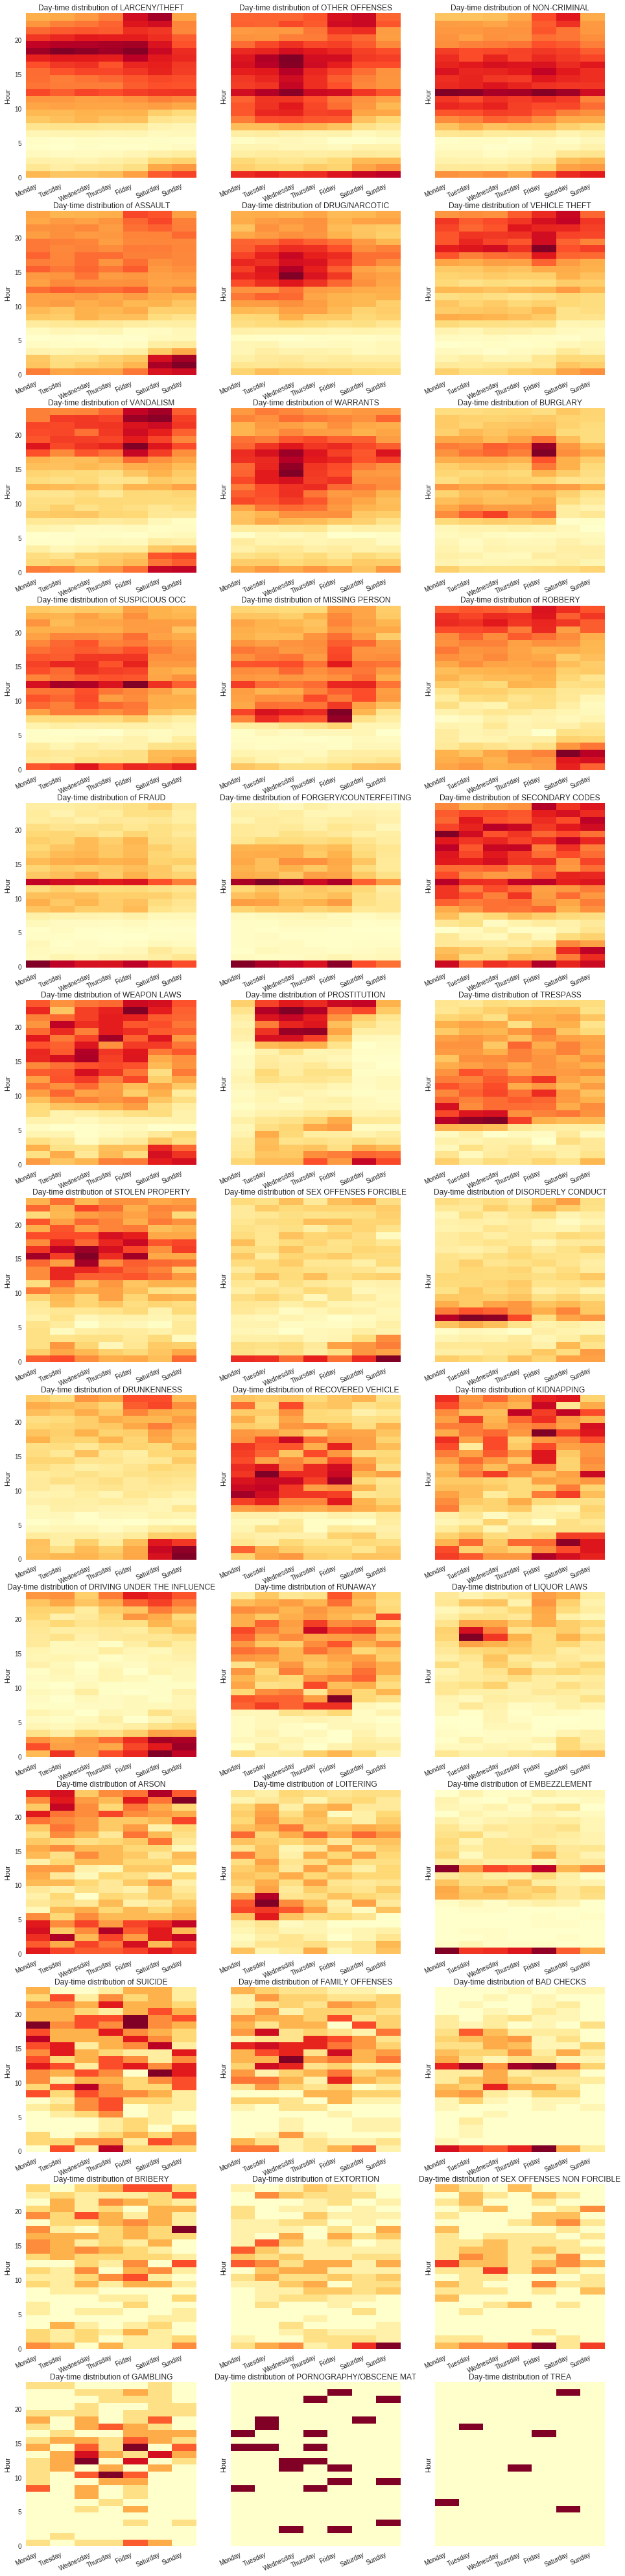

In [21]:
padded = all_categories.tolist()
while (len(padded) < 13*3):
    padded.append(None)
cat_array = np.reshape(padded, (13, 3))
f, axtuple = plt.subplots(cat_array.shape[0], cat_array.shape[1], sharey=True)
rows, cols = cat_array.shape

for j in range(rows):
    for i in range(cols):
        cat = cat_array[j, i]
        if (cat is not None):
            plt.sca(axtuple[j][i])
            heat_plot(train_df, cat)
            plt.xticks(rotation=25)
plt.gcf().set_size_inches(16, 70)

### For certain crimes it seems like noon and midnight are special, presumably because that's when the crimes are recorded. The crimes where this is seen are
- Fraud
- Forgery/Counterfeiting
- Sex Offenses Forcible
- Embezzlement


## Machine Learning time!

### These are some helper functions we'll use later to give our models the parameters we want.

In [22]:
def get_x_matrix(df, formula):
    x_vals = dmatrix(formula, data=df, return_type='dataframe')
    return x_vals
        
def get_x_y_matrices(df, formula, target, filt=True):
    
    x_vals = dmatrix(formula, data=df, return_type='dataframe')
    y_vals = df[target]
    if (filt):
        return filter_infrequent(x_vals, y_vals)
    return x_vals, y_vals
    
def filter_infrequent(x, y, threshold=3):
    counts = y.value_counts()
    for cat, count in counts.iteritems():
        if count < 3:
            x = x[y != cat]
            y = y[y != cat]
    return x, y

### These are some of the algorithms we used. We subclass them so that the `cross_val_predict` function uses probabilities, not outright predictions.

In [23]:
class ProbaRandomForestClassifier(RandomForestClassifier):
    def predict(self, X):
        return self.predict_proba(X)
        
class ProbaLogisticRegression(LogisticRegression):
    def predict(self, X):
        return self.predict_proba(X)
                                  
        
class ProbaBernoulliNB(BernoulliNB):
    def predict(self, X):
        return self.predict_proba(X)

### This is a Weighted Averager Class for when we want to compare how best to weight an ensemble algorithm.

In [24]:
class Weighted_Averager(BaseEstimator):
    
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights
        self.probas = [len(models)]
        
    def fit(self, x, y):
        for m in self.models:
            m.fit(x, y)
            
    def predict_probas_cv(self, x, y):
        probas = [None] * len(self.models)
        for i, m in enumerate(self.models):
            x_curr, y_curr = x, y
            if type(x) is list:
                x_curr = x[i]
            if type(y) is list:
                y_curr = y[i]
            probas[i] = cross_val_predict(m, x_curr, y_curr)
        self.probas = probas
            
    def calc_log_loss(self, y, weights=None):
        if (weights is None):
            weights = self.weights
        res = None
        for p, w in zip(self.probas, weights):
            if res is None:
                res = w * p
            else:
                res += w * p
        return log_loss(y, res)
            
    def predict_proba(self, x):
        res = None
        for m, w in zip(self.models, self.weights):
            if res is None:
                res = w * m.predict_proba(x)
            else:
                res += w * m.predict_proba(x)
                
        return res


### Let's try a Random Forest with ALL the features we had initially!

In [32]:
formula_ml = 'C(DayOfWeek) + C(PdDistrict) + C(Street_Corner) + X+Y+Hour+Month + Hour_Minutes + Weekend + WorkNextDay + Minutes_Since_New_Year + DayorNight + Hour:DayOfWeek'
x_vals, y_vals = get_x_y_matrices(train_df, formula_ml, 'Category')


clf = RandomForestClassifier(min_samples_leaf = 300)

print cross_val_score(clf, x_vals, y_vals, scoring='log_loss').mean()


-2.48558719306


In [33]:
forest = RandomForestClassifier(min_samples_leaf=300)

forest.fit(x_vals, y_vals)
importances = forest.feature_importances_

for i, c in zip(importances, x_vals.columns):
    print "%.3f" % i + ": " + c

0.000: Intercept
0.001: C(DayOfWeek)[T.Monday]
0.002: C(DayOfWeek)[T.Saturday]
0.003: C(DayOfWeek)[T.Sunday]
0.001: C(DayOfWeek)[T.Thursday]
0.001: C(DayOfWeek)[T.Tuesday]
0.001: C(DayOfWeek)[T.Wednesday]
0.027: C(PdDistrict)[T.CENTRAL]
0.016: C(PdDistrict)[T.INGLESIDE]
0.013: C(PdDistrict)[T.MISSION]
0.021: C(PdDistrict)[T.NORTHERN]
0.005: C(PdDistrict)[T.PARK]
0.005: C(PdDistrict)[T.RICHMOND]
0.029: C(PdDistrict)[T.SOUTHERN]
0.006: C(PdDistrict)[T.TARAVAL]
0.079: C(PdDistrict)[T.TENDERLOIN]
0.142: C(Street_Corner)[T.1]
0.006: Weekend[T.Weekend]
0.004: WorkNextDay[T.Work]
0.014: DayorNight[T.Night]
0.191: X
0.237: Y
0.069: Hour
0.003: Hour:DayOfWeek[T.Monday]
0.005: Hour:DayOfWeek[T.Saturday]
0.005: Hour:DayOfWeek[T.Sunday]
0.003: Hour:DayOfWeek[T.Thursday]
0.003: Hour:DayOfWeek[T.Tuesday]
0.003: Hour:DayOfWeek[T.Wednesday]
0.007: Month
0.089: Hour_Minutes
0.012: Minutes_Since_New_Year


### Let's try a  RandomForest with the just the features we're sure are important:

In [ ]:
formula_ml = 'C(PdDistrict) + C(Street_Corner) + X+Y+Hour'

x_vals, y_vals = get_x_y_matrices(train_df, formula_ml, 'Category')
min_leaves = np.round_(np.logspace(1, 3.5, num=10)) # values from 10 to 3100
n_estimators = [10, 30, 100]

parameters = {'min_samples_leaf':min_leaves, 'n_estimators': n_estimators}

clf = GridSearchCV(RandomForestClassifier(), parameters, scoring='log_loss')

clf.fit(x_vals, y_vals)

scores = [[], [], []]

for i, f in enumerate(clf.grid_scores_):
    scores[i % 3].append(f[1])
    
for n, score in zip(n_estimators, scores):
    
    plt.semilogx(min_leaves, score, label="%i estimators" % n)
    plt.xlabel('min_sample_leaf parameter')
    plt.ylabel('log-loss score')
    
plt.legend()

#### We found that a min_samples_leaf parameter of about 300 is optimal for our Random Forest.

In [34]:
formula_ml = 'C(PdDistrict) + C(Street_Corner) + X+Y+Hour '
x_vals, y_vals = get_x_y_matrices(train_df, formula_ml, 'Category')


clf = RandomForestClassifier(min_samples_leaf = 300)

print cross_val_score(clf, x_vals, y_vals, scoring='log_loss').mean()


-2.45894335411


### Let's see how well our model predicts each category of crime
##### The graph below shows our log-loss score for each category

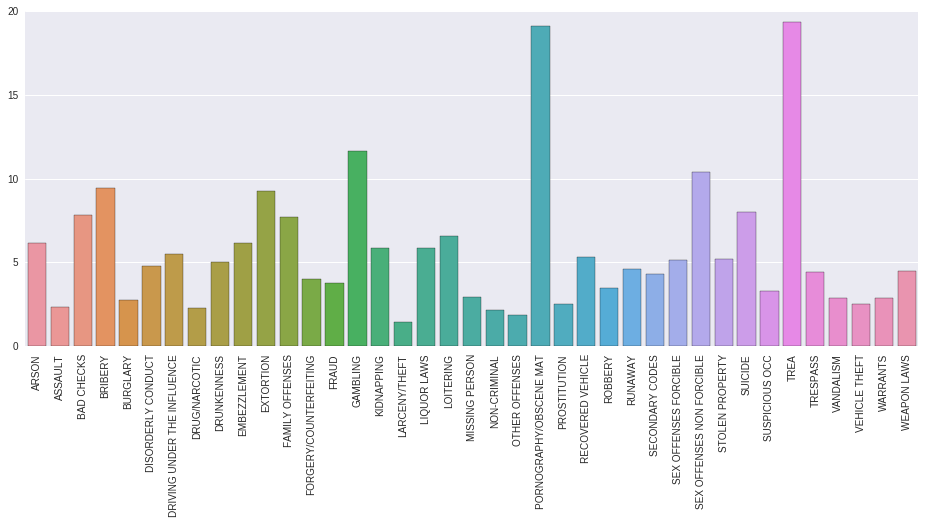

In [35]:
formula_ml = 'C(PdDistrict) + Street_Corner + X+Y+Hour'

x_vals, y_vals = get_x_y_matrices(train_df, formula_ml, 'Category')

lb = LabelBinarizer()
lb.fit(y_vals)
y_vals_matrix = lb.transform(y_vals)

clf_forest = ProbaRandomForestClassifier(min_samples_leaf=300)

predictions = cross_val_predict(clf_forest, x_vals, y_vals)
crimes = lb.classes_
scores = []

for i, crime in enumerate(crimes):
    indexor = (y_vals == crime).values
    scores.append(log_loss(y_vals_matrix[indexor], predictions[indexor]))
    
ax = sns.barplot(x=crimes, y=scores)
plt.sca(ax)
plt.xticks(rotation=90)
    
plt.gcf().set_size_inches(16, 6, forward=True)

### While the plot above is interesting, we will get more useful data if we normalize it for frequency.

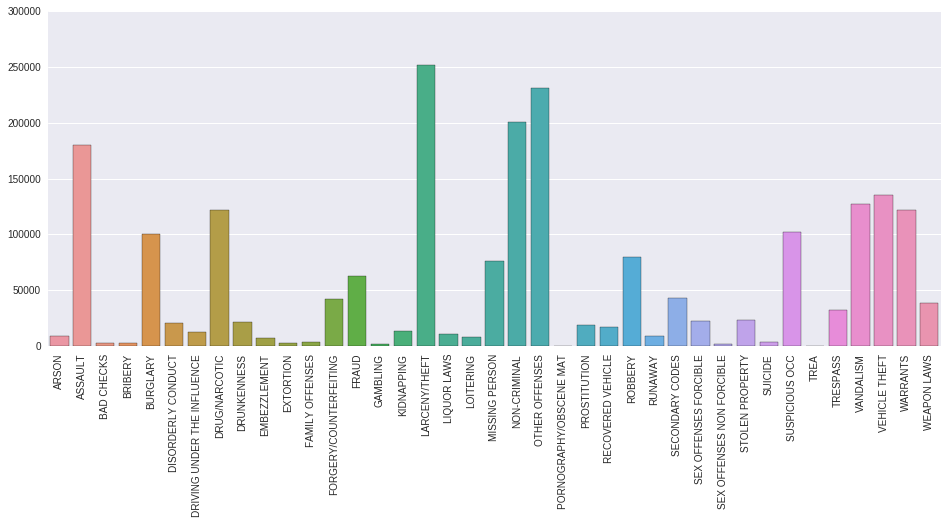

In [36]:
counts = y_vals.value_counts()
#print counts
weighted_scores = []
for i, crime in enumerate(crimes):
    weighted_scores.append(scores[i] * counts[crime])
ax = sns.barplot(x=crimes, y=weighted_scores)
plt.sca(ax)
plt.xticks(rotation=90)
    
plt.gcf().set_size_inches(16, 6, forward=True)

### The categories in which our model suffers from the highest log-loss values are the categories of crimes that are the most common.

In [ ]:
print ', '.join(all_categories[0:5])

LARCENY/THEFT, OTHER OFFENSES, NON-CRIMINAL, ASSAULT, DRUG/NARCOTIC


### Now let's try adding the midnight and noon features to our random forest.
##### This decision was made based on what we saw in the heat map plots above.

In [25]:
formula_ml = 'C(PdDistrict) + C(Street_Corner) + X+Y+Hour + Midnight + Noon'
x_vals, y_vals = get_x_y_matrices(train_df, formula_ml, 'Category')
clf = RandomForestClassifier(min_samples_leaf = 300)
print cross_val_score(clf, x_vals, y_vals, scoring='log_loss').mean()

-2.45333251162


### We worked with some other algorithms as well

##### Naieve Bayes BernoulliNB

In [26]:
clf = BernoulliNB()
print cross_val_score(clf, x_vals, y_vals, scoring='log_loss').mean()

-2.5763317466


The results of the Naieve Bayes Bernoulli algorithm are better than our original Random Forest with no parameter tweaking, but not as good as the Random Forest after overfitting has been accounted for by tuning its parameters.
Presumably, this algorithm does so well with log-loss scoring because it is never very certain of its predictions.

##### Logistic Regression

In [27]:
formula_ml = 'C(PdDistrict) + C(Street_Corner) + DayorNight + DayOfWeek + Midnight + Noon'
x_vals, y_vals = get_x_y_matrices(train_df, formula_ml, 'Category')
clf = LogisticRegression()
print cross_val_score(clf, x_vals, y_vals, scoring='log_loss').mean()

-2.55106584412


So far, our random forest has performed better than both the Bernulli and Logistic Regression algorithms,but we wanted to see if by ensembling/weighting multiple algorithms together we could achieve something greater.

In [28]:
clf_forest = ProbaRandomForestClassifier(min_samples_leaf=300)
clf_logistic = ProbaLogisticRegression()
clf_bernoulli = ProbaBernoulliNB()

### Comparing best proportiton of Random Forest to Bernoulli
We wanted to see whether a combination of Random Forest and Bernoulli would work better than the random forest alone.

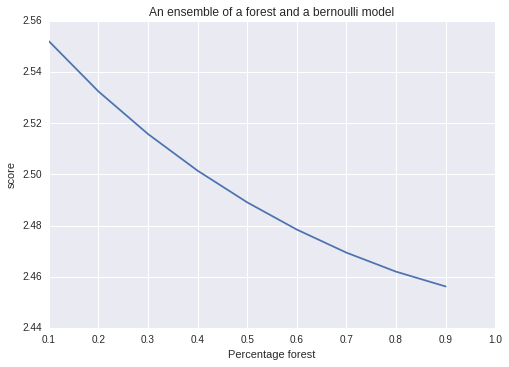

In [29]:
formula_ml = 'C(PdDistrict) + C(Street_Corner) + X+Y+Hour + Midnight + Noon'
x_vals, y_vals = get_x_y_matrices(train_df, formula_ml, 'Category')

w_a = Weighted_Averager([clf_forest, clf_bernoulli], [0.5, 0.5])
w_a.predict_probas_cv(x_vals, y_vals)
weights = np.linspace(0.1, 0.9, 9)
scores = []
for w in weights:
    s = w_a.calc_log_loss(y_vals, weights=[w, 1-w])
    scores.append(s)
    
plt.plot(weights, scores)
plt.xlabel("Percentage forest")
plt.title("An ensemble of a forest and a bernoulli model")
plt.ylabel("score")

### It appears that the more heavily we weight the forest and the less heavily we weight Bernoulli, the better our model scores. Because of this, we have chosen to not use Bernoulli in our final model.

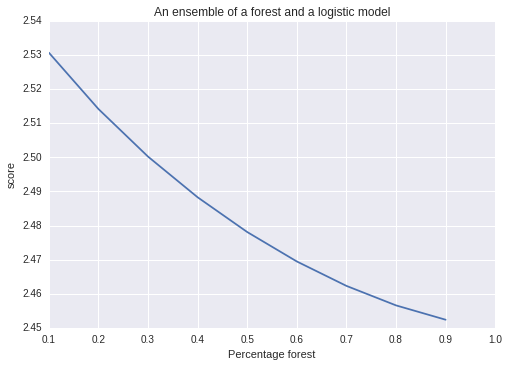

In [30]:
formula_ml = 'C(PdDistrict) + C(Street_Corner) + X+Y+Hour + Midnight + Noon'
x_vals, y_vals = get_x_y_matrices(train_df, formula_ml, 'Category')
formula_ml_log = 'C(PdDistrict) + C(Street_Corner) + DayorNight + DayOfWeek + Midnight + Noon'
x_vals_log, y_vals_log = get_x_y_matrices(train_df, formula_ml_log, 'Category')
w_a = Weighted_Averager([clf_forest, clf_logistic], [0.5, 0.5])
w_a.predict_probas_cv([x_vals, x_vals_log], y_vals)
weights = np.linspace(0.1, 0.9, 9)
scores = []
for w in weights:
    s = w_a.calc_log_loss(y_vals, weights=[w, 1-w])
    scores.append(s)    
plt.plot(weights, scores)
plt.title("An ensemble of a forest and a logistic model")
plt.xlabel("Percentage forest")
plt.ylabel("score")


It appears once again that the more heavily we weight the forest, the better our model scores. Because of this, we have chosen to  use the Random Forest in our final model without ensembling with other algorithms.


### Saving to .csv for Kaggle Submission

In [31]:
alg = RandomForestClassifier(min_samples_leaf= 300)
formula_ml = 'C(PdDistrict) + C(Street_Corner) + X+Y+Hour + Midnight + Noon'
x_train, y_train = get_x_y_matrices(train_df, formula_ml, 'Category')
alg.fit(x_train, y_train)
predictions = alg.predict_proba(get_x_matrix(preprocess(test,drop=False), formula_ml))
predictions = pd.DataFrame(predictions, index=test.index, columns=alg.classes_)
predictions.to_csv("predictions.csv", index_label="Id")

# Our Model Scored: 2.42
### 215 on the leaderboard